# TP classification de sons à rendre

Tom Bevan (tom.bevan@etu.unice.fr)
Vinh Faucher (vinh.faucher@etu.unice.fr)

Polytech SI3 - SSII - 2021-22

# Données



In [86]:
#les imports nécessaires pour la suite
import matplotlib.pyplot as plt
import numpy as np 
import glob
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans, MiniBatchKMeans

from sklearn.datasets import fetch_lfw_people
import cv2
from sklearn.model_selection import train_test_split

from sklearn import svm

## Les données
On va utiliser le jeu de données "lfw_people" en filtrant les classes contenant minimum 100 images.

In [69]:
lfw = fetch_lfw_people(min_faces_per_person=100, resize=1)
# à adapter selon l'ordinateur
verbose = True
taille_mfcc = 13
X = lfw.images
y = lfw.target
Xtrain, Xtest, yTrain, yTest = train_test_split(X, y, test_size=0.25, random_state=33)

False


C:\Users\Vinh\AppData\Local\Temp\ipykernel_35508\1665713061.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(X==y)


# On crée les sifts

In [29]:
"""Définition des méthodes"""

def build_sifts_from_image_list(images, siftsRes, sifts_per_image=[]):

    """
    Remplit le numpy array sifts passé en paramètres avec les SIFTs de toutes les images.

    Arguments:
         images: une liste d'images, dont on souhaite calculer les SIFTs.
         siftsRes: le numpy array à remplir
         sifts_per_image: le tableau auquel on ajoute le nombre de SIFTs de chaque image.
    """

    for image in images:
        gray_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(gray_image, None)
        #print(siftsRes.shape)
        #print(des)
        siftsRes = np.append(siftsRes, des, axis=0)
        sifts_per_image.append(len(des))

    return siftsRes


sifts = np.empty(shape = (0, 128))
sifts_per_image = []

sifts = build_sifts_from_image_list(Xtrain, sifts, sifts_per_image)
#print(sifts.shape)

(63018, 128)


## Partitionnement en K-means

In [32]:
def build_clusters_list(sifts, k = 10):

    """
    Partitionne les SIFTs en k clusters et retourne le cluster auquel appartient chaque SIFT.

    Arguments:
        sifts: le numpy array de SIFTs à partitionner.
        k: le nombre de clusters souhaité.
    """

    kMeans = MiniBatchKMeans(n_clusters = k)
    kMeans.fit(sifts)
    return kMeans.labels_


def build_images_bows(labels, sifts_per_image, k = 10):

    """
    Construit un numpy array contenant les BOWs de chaque image.

    Arguments:
        labels: les labels de chaque SIFTs, CAD à quel cluster appartient chaque SIFT.
        sifts_per_image: le tableau décrivant le nombre de SIFT dans chaque image.
        k: le nombre de clusters.
    """

    all_bows = np.zeros(shape = (len(sifts_per_image), k))

    parcours = 0
    parcours_bis = 0
    for sift_amount in sifts_per_image:
        bow = np.zeros(k)
        for i in range(parcours + sift_amount):
            bow[labels[i]] += 1/sift_amount
        parcours += sift_amount
        all_bows[parcours_bis] = bow
        parcours_bis += 1

    return all_bows

In [33]:
"""Création des clusters"""

labels = build_clusters_list(sifts)

In [34]:
"""Construction des BOWs"""

bows = build_images_bows(labels, sifts_per_image)

In [35]:
"""Tests"""

print(labels)
print(bows.shape)
print(bows[0])
print(sum(bows[0]))

[8 6 8 ... 8 9 8]
(855, 10)
[0.11320755 0.05660377 0.13207547 0.01886792 0.0754717  0.05660377
 0.20754717 0.13207547 0.18867925 0.01886792]
0.9999999999999999


### Classification

In [82]:
"""Régression logistique puis classification"""

logisticRegr = LogisticRegression(max_iter = 100000)

scaler = preprocessing.StandardScaler().fit(bows)
xtrain = scaler.transform(bows)
logisticRegr.fit(xtrain, yTrain)

LogisticRegression(max_iter=100000)

In [83]:
ypred = logisticRegr.predict(xtrain)
print("train F1 score = ", f1_score(yTrain, ypred, average = 'micro'))
print("train accuracy score = ", accuracy_score(yTrain, ypred))


train F1 score =  0.47953216374269003
train accuracy score =  0.47953216374269003


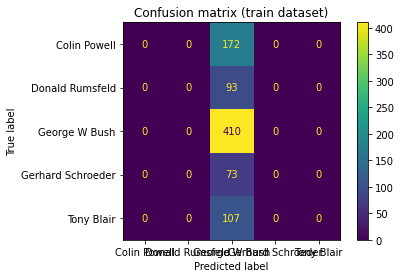

In [84]:
cm = confusion_matrix(yTrain, ypred, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lfw.target_names)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')
plt.show()

In [93]:
classif = svm.SVC(kernel='linear')
classif.fit(bows, yTrain)


SVC(kernel='linear')

https://www.geeksforgeeks.org/classifying-data-using-support-vector-machinessvms-in-python/

In [92]:
print('prediction class for [2,2]', classif.predict([[10., 10.]]))
print('support vectors: ', classif.support_vectors_)

ValueError: X has 2 features, but SVC is expecting 10 features as input.